In [1]:
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader

from monai.config import print_config
from monai.transforms import \
    Compose, LoadPNG, AddChannel, ScaleIntensity, ToTensor, RandRotate, RandFlip, RandZoom
from monai.networks.nets import densenet121
from monai.metrics import compute_roc_auc

from datetime import datetime
import pandas as pd

pd.set_option('display.max_colwidth', 250)
pd.set_option('display.max_columns', None)

np.random.seed(0)

### Define variables

In [3]:
working_directory = '/mnt/datasets/fastcovnet/'
columnToPredict = 'ViewPosition'
resolution = '224'
path_saved_model = os.path.expanduser("~")+'/best_metric_'+columnToPredict+'_'+resolution+'.pth'

epoch_num = 30

In [4]:
# Cohort read
data = pd.read_csv(os.path.join(working_directory,'cohort_viewposition_20201116.csv'),"|")

# It's already done during cohort creation, but just in case we've a different columnToPredict or just to be sure we have it as string and not number.
# NULL removal of predicted variable
data = data[data[columnToPredict].isna()==False]

# Convert columnToPredict to string, just in case they're numbers, so we don't have any errors.
data[columnToPredict] = data[columnToPredict].astype(str)

In [6]:
# Classes to predict
class_names = sorted(data[columnToPredict].unique())
num_class = len(class_names)
data[columnToPredict].value_counts()

PA    67145
LL    49328
AP    47648
Name: ViewPosition, dtype: int64

In [8]:
data[columnToPredict] = pd.Categorical(data[columnToPredict])
data["to_predict"] = data[columnToPredict].cat.codes

image_file_list = data.path_jpg.tolist()
image_label_list = data.to_predict.tolist()

num_total = len(image_label_list) 

### Visualise some randomly picked examples from the dataset

In [ ]:
fig, ax = plt.subplots(3,3, figsize=(20, 20))
for i,k in enumerate(np.random.randint(num_total, size=9)):
    im = Image.open(image_file_list[k])
    arr = np.array(im)
    ax[i//3][i%3].imshow(arr, cmap='gray', vmin=0, vmax=255)
    ax[i//3][i%3].set_xlabel(str(k)+' - '+class_names[image_label_list[k]], fontsize=15)

## Prepare training, validation and test data lists

In [10]:
valid_frac, test_frac = 0.1, 0.1
trainX, trainY = [], []
valX, valY = [], []
testX, testY = [], []

# Data is already random, so we can create datasets sequentially

for i in range(num_total):
    if i < (valid_frac * num_total):
        valX.append(image_file_list[i])
        valY.append(image_label_list[i])
    elif i < ((valid_frac + test_frac) * num_total):
        testX.append(image_file_list[i])
        testY.append(image_label_list[i])
    else:
        trainX.append(image_file_list[i])
        trainY.append(image_label_list[i])

print("Training count =",len(trainX),"Validation count =", len(valX), "Test count =",len(testX))

Training count = 131296 Validation count = 16413 Test count = 16412


## Define MONAI transforms, Dataset and Dataloader to pre-process data

In [11]:
train_transforms = Compose([
    LoadPNG(image_only=True),
    AddChannel(),
    ScaleIntensity(),
    RandRotate(range_x=15, prob=0.5, keep_size=True),
    RandFlip(spatial_axis=0, prob=0.5),
    RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5, keep_size=True),
    ToTensor()
])

val_transforms = Compose([
    LoadPNG(image_only=True),
    AddChannel(),
    ScaleIntensity(),
    ToTensor()
])

In [12]:
class MedNISTDataset(Dataset):

    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]

train_ds = MedNISTDataset(trainX, trainY, train_transforms)
train_loader = DataLoader(train_ds, batch_size=80, shuffle=True, num_workers=10)

val_ds = MedNISTDataset(valX, valY, val_transforms)
val_loader = DataLoader(val_ds, batch_size=80, num_workers=10)

test_ds = MedNISTDataset(testX, testY, val_transforms)
test_loader = DataLoader(test_ds, batch_size=80, num_workers=10)

## Define network and optimizer
1. Set learning rate for how much the model is updated per batch.
2. Set total epoch number, as we have shuffle and random transforms, so the training data of every epoch is different.
And as this is just a get start tutorial, let's just train 4 epochs.
If train 10 epochs, the model can achieve 100% accuracy on test dataset.
3. Use DenseNet from MONAI and move to GPU devide, this DenseNet can support both 2D and 3D classification tasks.
4. Use Adam optimizer.

In [13]:
device = torch.device("cuda:0")
model = densenet121(
    spatial_dims=2,
    in_channels=1,
    out_channels=num_class
).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
val_interval = 1 # How often will we validate. 1 means it validates in every epoch

In [14]:
# If already exists, load model
# Let's load the best model and our current training state
try:
    checkpoint = torch.load(path_saved_model)
except:
    print("Model NOT loaded")
else:
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    epoch_loss_values = checkpoint['epoch_loss_values']
    metric_values = checkpoint['metric_values']
    print("Model has been loaded")

Model has been loaded


In [15]:
# Checkpoint definition. We create a checkpoint to save not only the state of the model, but also its optimizer state (since it's Adam, it has memory). Looks like it's not a big deal if you don't restore, but you'll need a little more epochs to finish training with the same results.
if 'best_metric' not in vars():
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values = list()
    metric_values = list()
    checkpoint = {}

## Model training
Execute a typical PyTorch training that run epoch loop and step loop, and do validation after every epoch.
Will save the model weights to file if got best validation accuracy.

In [ ]:
for epoch in range(epoch_num):
    print('-' * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")
    model.train()
    epoch_loss = 0
    step = 0
    start = datetime.now()
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        if step % 20 == 1:
            print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")
            print(f'Estimated total time: {(datetime.now() - start).total_seconds()/60/20*epoch_num*(len(train_ds) // train_loader.batch_size)} minutes')
            start = datetime.now()
        epoch_len = len(train_ds) // train_loader.batch_size
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            auc_metric = compute_roc_auc(y_pred, y, to_onehot_y=True, softmax=True)
            metric_values.append(auc_metric)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if auc_metric > best_metric:
                best_metric = auc_metric
                best_metric_epoch = epoch + 1
                checkpoint['model'] = model.state_dict()
                checkpoint['optimizer'] = optimizer.state_dict()
                checkpoint['epoch_loss_values'] = epoch_loss_values
                checkpoint['metric_values'] = metric_values
                torch.save(checkpoint, path_saved_model)
                print('saved new best metric model')
            print(f"current epoch: {epoch + 1} current AUC: {auc_metric:.4f}"
                  f" current accuracy: {acc_metric:.4f} best AUC: {best_metric:.4f}"
                  f" at epoch: {best_metric_epoch}")
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

## Save the model

In [17]:
# Let's save model and current status
checkpoint['optimizer'] = optimizer.state_dict()
checkpoint['epoch_loss_values'] = epoch_loss_values
checkpoint['metric_values'] = metric_values

torch.save(checkpoint, path_saved_model)

## Load the model

In [18]:
# Let's load the best model and our current training state
checkpoint = torch.load(path_saved_model)

model.load_state_dict(checkpoint["model"])
optimizer.load_state_dict(checkpoint["optimizer"])

epoch_loss_values = checkpoint['epoch_loss_values']
metric_values = checkpoint['metric_values']

## Plot the loss and metric

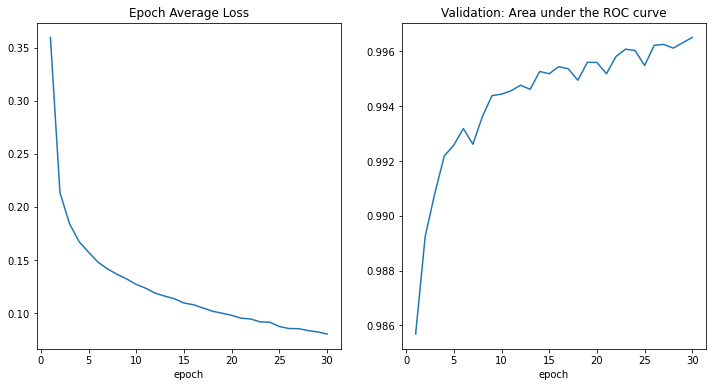

In [15]:
plt.figure('train', (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel('epoch')
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Validation: Area under the ROC curve")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel('epoch')
plt.plot(x, y)
plt.show()

## Evaluate the model on test dataset
After training and validation, we already got the best model on validation test.
We need to evaluate the model on test dataset to check whether it's robust and not over-fitting.
We'll use these predictions to generate a classification report.

In [16]:
model.eval()
y_true = list()
y_pred = list()
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())
            
# Test:
# 	y = m(x)
# 	Passem y a llista
# 	Passem labels a llista
# 	Executem sklearn per treure les mètriques

In [17]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

          AP     0.9475    0.9596    0.9535      4854
          LL     0.9821    0.9801    0.9811      4935
          PA     0.9750    0.9674    0.9712      6623

    accuracy                         0.9689     16412
   macro avg     0.9682    0.9690    0.9686     16412
weighted avg     0.9690    0.9689    0.9690     16412



REVIEW OF RESULTS

In [ ]:
# MISSES

fig, ax = plt.subplots(3,3, figsize=(20, 20))
for i,k in enumerate(np.random.randint(len(fallos), size=9)):
    im = Image.open(fallos["full_path"].iloc[k])
    arr = np.array(im)
    ax[i//3][i%3].imshow(arr, cmap='gray', vmin=0, vmax=255)
    ax[i//3][i%3].set_xlabel("Predicted: "+class_names[fallos["y_pred"].iloc[k]]+"   Real: "+class_names[fallos["y_true"].iloc[k]]+"\n"+fallos["filename"].iloc[k], fontsize=11)

In [ ]:
# HITS

fig, ax = plt.subplots(3,3, figsize=(20, 20))
for i,k in enumerate(np.random.randint(len(encerts), size=9)):
    im = Image.open(encerts["full_path"].iloc[k])
    arr = np.array(im)
    ax[i//3][i%3].imshow(arr, cmap='gray', vmin=0, vmax=255)
    ax[i//3][i%3].set_xlabel(class_names[encerts["y_pred"].iloc[k]]+"\n"+encerts["filename"].iloc[k], fontsize=11)

In [15]:
full_dataset = pd.read_csv(os.path.join(working_directory,'full_covid_dataset.csv'),"|")

In [18]:
BodyPartExamined = ["CHEST", "TORAX", "THORAX"]

In [19]:
# We'll do the same filters that were used to train this network

to_score = full_dataset[full_dataset.BodyPartExamined.isin(BodyPartExamined)]
to_score = to_score[to_score.ViewPosition.isna()]

In [21]:
scoreX = to_score.path_jpg.tolist()

score_ds = MedNISTDataset(scoreX, ['0'] * len(scoreX), val_transforms)
score_loader = DataLoader(score_ds, batch_size=1200, num_workers=10)

In [22]:
model.eval()
y_true = list()
y_pred = list()
with torch.no_grad():
    for score_data in score_loader:
        score_images = score_data[0].to(device)
        pred = model(score_images).argmax(dim=1)
        for i in range(len(pred)):
            #y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

In [23]:
y_pred_desc = []

for i in range(len(y_pred)):
    y_pred_desc.append(class_names[y_pred[i]])

resultat_score = pd.DataFrame(
    {'full_path': scoreX,
     'y_pred': y_pred,
     'y_pred_desc' : y_pred_desc
    })

resultat_score["filename"] = resultat_score["full_path"].str.split('/').str[-1]

In [ ]:
# RESULTS

fig, ax = plt.subplots(3,3, figsize=(20, 20))
for i,k in enumerate(np.random.randint(len(resultat_score), size=9)):
    im = Image.open(resultat_score["full_path"].iloc[k])
    arr = np.array(im)
    ax[i//3][i%3].imshow(arr, cmap='gray', vmin=0, vmax=255)
    ax[i//3][i%3].set_xlabel("Predicted: "+class_names[resultat_score["y_pred"].iloc[k]]+"\n"+resultat_score["filename"].iloc[k], fontsize=11)

In [26]:
full_dataset = full_dataset.merge(resultat_score, how='left', left_on='path_jpg', right_on='full_path')

In [27]:
full_dataset["ViewPosition"] = np.where((full_dataset.ViewPosition.isna()), full_dataset.y_pred_desc,full_dataset.ViewPosition)

In [28]:
full_dataset = full_dataset.drop(columns=["full_path", "y_pred", "y_pred_desc", 'filename'])

In [29]:
# Cohort save
full_dataset.to_csv(path_or_buf=os.path.join(working_directory,'full_covid_dataset_inferenceVP.csv'), index=False, sep='|')